<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [3]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [109]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [110]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [111]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [112]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [113]:
def get_temps_for_forcing_fn(forcing_fn):
  T = np.zeros(Nt)
  theta = np.zeros(Nt)
  T[0] = 0
  theta[0] = 0
  for i in range(0, Nt-1):
      T[i+1] = T[i] + dt * (forcing_fn(i) - gamma * (T[i] - theta[i])) / C_s
      theta[i+1] = theta[i] + dt * gamma * (T[i] - theta[i]) / C_d
  return T, theta

In [114]:
def get_plots_for_temps(T, theta):
  plt.plot(t,T,'r-')
  plt.plot(t,theta,'b-')
  plt.legend(['Surface temperature','Deep ocean temperature'])
  plt.xlabel('Time (years)')

In [115]:
def get_plots_for_forcing_fn(forcing_fn):
  T, theta = get_temps_for_forcing_fn(forcing_fn)
  get_plots_for_temps(T, theta)

After you are finished, run the cell below to plot the results

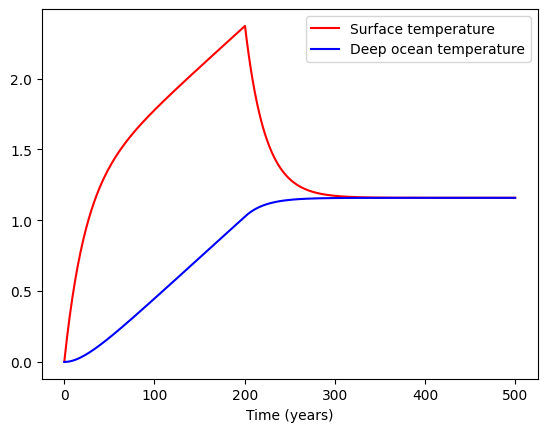

In [116]:
get_plots_for_forcing_fn(F)

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain the response of T and Theta to the forcing by defining characteristic timescales from the box model equations?

At the start of the model run, the temperature at the surface is increasing due to solely the forcing function, and the temperature of the ocean is constant. However, immediately after the start of the run, the temperatures start to diverge and the increase in surface temperature is slowed as it's brought closer to that of the ocean, and the temperature of the ocean is pulled up to be closer to that of the surface.

There are a few characteristic timescales, the very start of the model, that of the surface near the start, that of the ocean near the start, and that of the system after F is turned off:

1. At the very beginning. As discussed above, at this point, the difference in atmosphere and ocean temperatures is negligible (T-Theta =0), so the ocean isn't changing temperature and the surface is varying as DT/dt = F(t)/C_s. At this point, a characteristic timescale for this is t ~ C_S * T / F(t).

2. Once the temperatures diverge and T-Theta is substantial, but before the forcing function becomes 0 degrees kelvin. At this point:

dT/dt = (1 - γT) / C_s

t = γ/C_s * ln|1-γT| + C

e^((t-C)*C_s/γ) = 1- γT

T = (1-e^((t*C_s/γ - C))/γ

And so we see an appropriate scaling factor for t is C_s / γ

3. We can also perform unit analysis to find the characteristic timescale of the ocean:

C_d * dTheta/dt = γ (T-theta)

dTheta/dt = γ (T-theta) / C_d

dt = C_d /(γ * (T-theta))  * dTheta

[t] = C_d/(γ * T) * T

[t] = C_d/ γ

So a characteristic timescale of ocean change is C_d / γ

4. After the forcing function is turned off (F = 0):

Define u = T - Theta

du/dt = dT/dt - dTheta/dt

du/dt =  - γu/C_s - γu/C_d

du/dt = -γu(1/C_s + 1/C_d)

du/u = -γ(1/C_s + 1/C_d) dt

integrate both sides

ln|u| = - γ * (1/C_s + 1/C_d) * t + C

u = e^(- γ * (1/C_s + 1/C_d) * t) * e^C

so a characteristic timescale after F is 0 is (γ * (1/C_s + 1/C_d))^-1

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

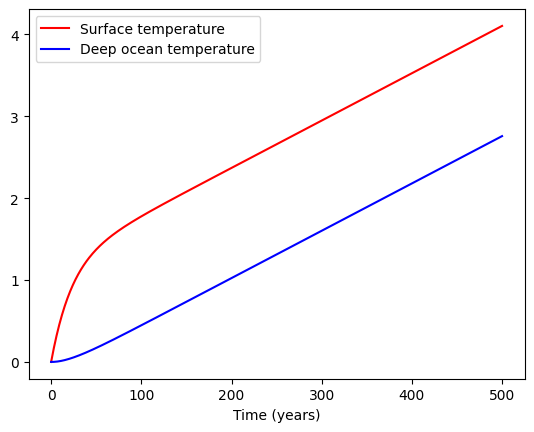

In [117]:
def linear_forcing_fn(t):
  return 1

get_plots_for_forcing_fn(linear_forcing_fn)

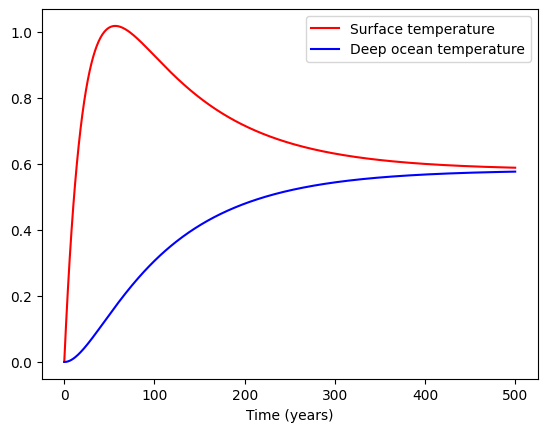

In [118]:
import math

def exp_decay_forcing_fn(t):
  return math.exp(-0.01 * t)

get_plots_for_forcing_fn(exp_decay_forcing_fn)

1. linear forcing function: This function assumes that the net surface heat flux remains constant (an incredibly bad case emissions scenario). In this case, the temperatures of the surface and ocean grow unbounded and linearly, with the ocean lagging behind the surface because the ocean has a higher heat capacity and is only a proxy of the forcing function through the surface temperature.

2. Exponential decay forcing function: In this case, the heat flux starts at 1, but decays exponentially as time goes on, representing greenhouse gas emissions slowly being brought under control. In this case, the surface temperature increases rapidly, before peaking at roughly 70 years at ~1 degree kelvin, and the ocean and surface approach ~.58 degrees Kelvin (noticeably at a much longer timescale than when the forcing function was turned off).

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [ ]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [ ]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    # print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [ ]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    # print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [9]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [56]:
import time
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [57]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

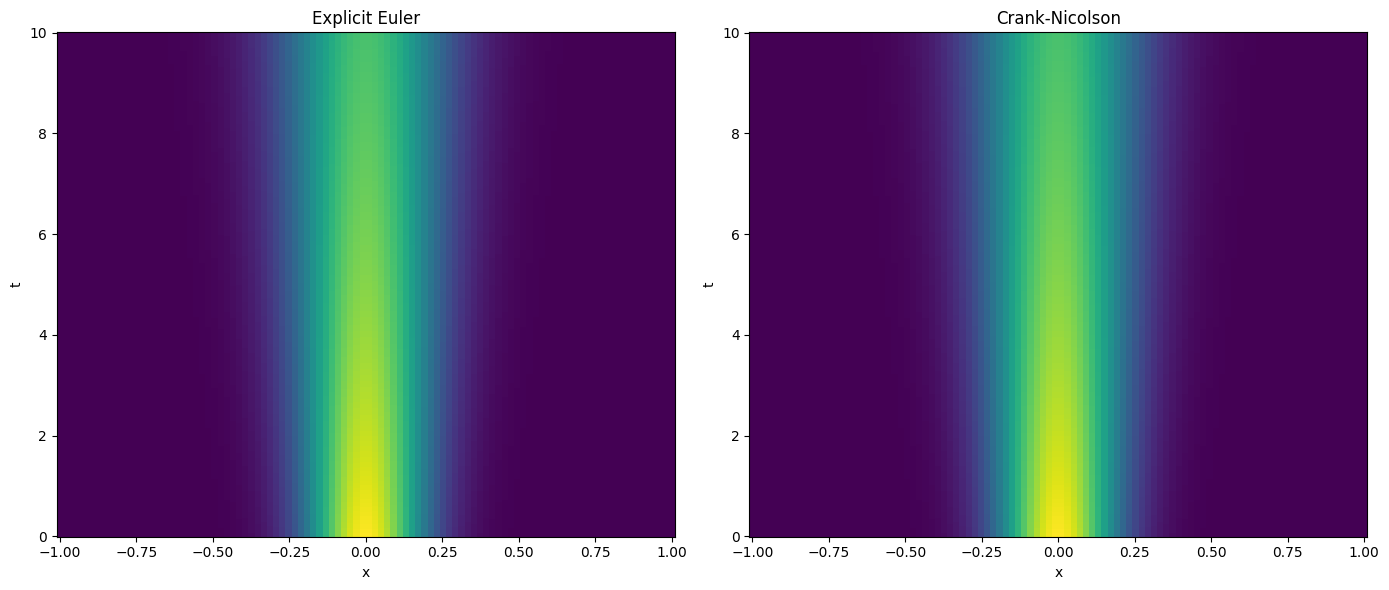

In [58]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

As kappa increased, I started to notice a difference at .01, and drastic difference at .02, nonsense at .25, and broke at .035.

Plot everything to show

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

In [63]:
def get_exact_solution_at_x(x, kappa):
  # only evaluating at final time t = 20
  t = 20
  return (4*np.pi*kappa*t)**(-0.5)*np.exp(-x**2 / (4*kappa*t))

In [64]:
kappa = .01

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times

y = get_exact_solution_at_x(x, kappa)
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

EE_final = c_EE[:,-1]
CN_final = c_CN[:,-1]

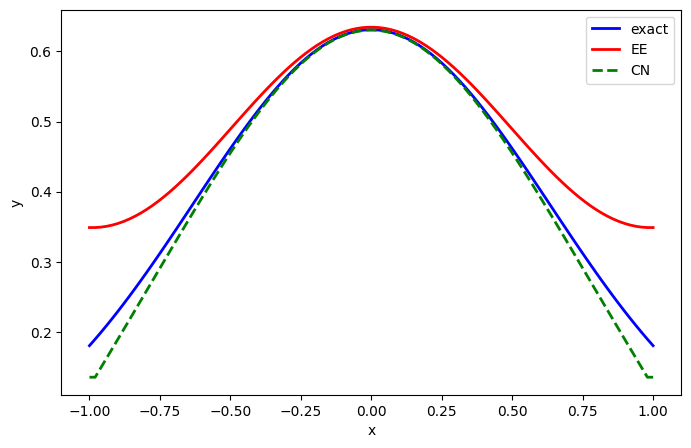

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b-', label='exact', linewidth=2)
plt.plot(x, EE_final, 'r', label='EE', linewidth=2)
plt.plot(x, CN_final, 'g--', label='CN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

In [66]:
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100
x = np.linspace(x_start, x_end, Nx)

kappa = .001

In [105]:
# Plot the results
errors_ee = []
errors_cn = []
delta_ts = []

num_timesteps = np.arange(10,1000,5)
exact = (4*np.pi*kappa*20)**(-0.5)*np.exp(-0**2 / (4*kappa*20))

for Nt in num_timesteps:
  t = np.linspace(t_start, t_end, Nt)
  dt = t[1] - t[0]

  ee = EE(x, t, kappa)
  cn = CN(x, t, kappa)

  middlePoint = len(ee) // 2
  ee_error = np.abs(exact - ee[middlePoint,-1])
  cn_error = np.abs(exact - cn[middlePoint,-1])

  delta_ts.append(dt)
  errors_ee.append(ee_error)
  errors_cn.append(cn_error)


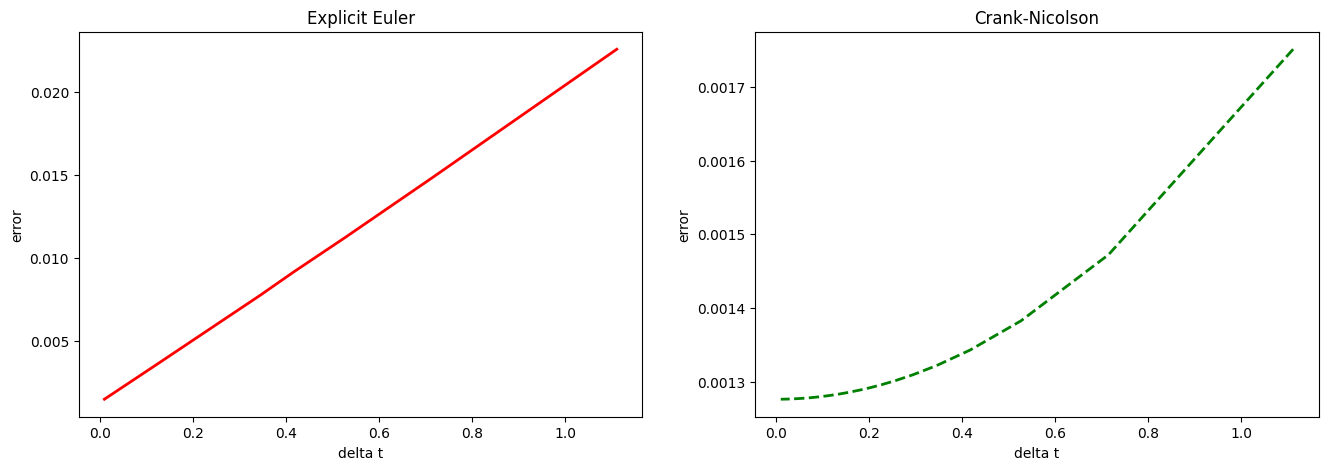

In [106]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(delta_ts, errors_ee, 'r', label='EE', linewidth=2)
plt.xlabel('delta t (s)')
plt.ylabel('error')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.plot(delta_ts, errors_cn, 'g--', label='CN', linewidth=2)
plt.xlabel('delta t (s)')
plt.ylabel('error')
plt.title('Crank-Nicolson')

plt.show()


We can see from the Explicit Euler graph that error increases linearly as delta t increases, and from the crank nicolson curve that error increases quadratically as delta t increases. This makes sense as explicit euler is first order accurate (it truncates local error in big O of delta t^2, resulting in accumulated globaly error of O(delta t)), whereas Crank-Nicolson is second order accurate (it truncates local error in big O of delta t^3, resulting in accumulated globaly error of O(delta t^2)). One thing to note here is the scale of the y axis - although crank nicolson will perform worse if you extrapolate incrases in delta t from this graph, for the time range shone, it's consistently better than the explicit euler.

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

In [197]:
error_tolerance = 0.1
num_trials_for_runtime = 5

min_timestep = 2
max_timestep = 2000
timestep_step_size = 10

min_kappa = .001
max_kappa = .05
kappa_step_size = .001

In [198]:
def get_error(final_timestep, exact_solution):
  # Use root mean squared error
  return np.sqrt(np.mean((final_timestep - exact_solution) ** 2))

In [199]:
def get_lowest_fidelity_resolution_within_threshold(kappa, error_tolerance, timestep_method):
    num_timesteps = np.arange(min_timestep,max_timestep,timestep_step_size)
    x_start = -1
    x_end = 1
    Nx = 100
    x = np.linspace(x_start, x_end, Nx)
    exact = (4*np.pi*kappa*20)**(-0.5)*np.exp(-x**2 / (4*kappa*20))
    best_Nt = num_timesteps[-1]
    best_error = 0
    for Nt in num_timesteps[::-1]:
      t = np.linspace(t_start, t_end, Nt)
      result = timestep_method(x, t, kappa)
      error = get_error(result[:,-1], exact)
      if error > error_tolerance:
        return best_Nt
      best_Nt = Nt
      best_error = error
    if best_error < error_tolerance:
      return best_Nt
    return -1

In [200]:
def stimulate_runtime(best_nt, kappa, timestep_method):
  runtimes = []

  x_start = -1
  x_end = 1
  Nx = 100
  x = np.linspace(x_start, x_end, Nx)
  t = np.linspace(t_start, t_end, Nt)
  for n in range(num_trials_for_runtime):
    start_time = time.time()
    timestep_method(x,t,kappa)
    end_time = time.time()
    runtimes.append(end_time - start_time)
  return np.average(runtimes)

In [201]:
def get_runtime_of_method(kappa, error_tolerance, timestep_method):
  best_nt = get_lowest_fidelity_resolution_within_threshold(kappa, error_tolerance, timestep_method)
  if best_nt == -1:
    return 0, 0
  return stimulate_runtime(best_nt, kappa, timestep_method), best_nt

In [202]:
kappas = np.arange(min_kappa, max_kappa, kappa_step_size)
ee_runtimes = []
cn_runtimes = []

ee_nts = []
cn_nts = []

i = 0
for k in kappas:
  ee_runtime, ee_nt = get_runtime_of_method(k, error_tolerance, EE)
  cn_runtime, cn_nt = get_runtime_of_method(k, error_tolerance, CN)

  ee_runtimes.append(ee_runtime)
  cn_runtimes.append(cn_runtime)

  ee_nts.append(ee_nt)
  cn_nts.append(cn_nt)

  print(100 * i / len(kappas), "% done", ee_nt, cn_nt)
  i += 1


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


0.0 % done 12 2
2.0408163265306123 % done 92 2
4.081632653061225 % done 142 2
6.122448979591836 % done 192 2
8.16326530612245 % done 242 2
10.204081632653061 % done 292 2
12.244897959183673 % done 342 2
14.285714285714286 % done 392 2
16.3265306122449 % done 442 2
18.367346938775512 % done 492 2
20.408163265306122 % done 542 2
22.448979591836736 % done 592 2
24.489795918367346 % done 642 12
26.53061224489796 % done 682 12
28.571428571428573 % done 732 12
30.612244897959183 % done 782 112
32.6530612244898 % done 832 242
34.69387755102041 % done 882 372
36.734693877551024 % done 932 522
38.775510204081634 % done 982 682
40.816326530612244 % done 1032 842
42.857142857142854 % done 1082 1022
44.89795918367347 % done 1132 1212
46.93877551020408 % done 1172 1402
48.97959183673469 % done 1222 1602
51.02040816326531 % done 1272 1822


/tmp/ipython-input-2924108368.py:21: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


53.06122448979592 % done 1322 1992
55.10204081632653 % done 1372 1992
57.142857142857146 % done 1422 1992
59.183673469387756 % done 1472 1992
61.224489795918366 % done 1522 1992
63.265306122448976 % done 1572 1992
65.3061224489796 % done 1612 1992
67.34693877551021 % done 1662 1992
69.38775510204081 % done 1712 1992
71.42857142857143 % done 1762 1992
73.46938775510205 % done 1812 1992
75.51020408163265 % done 1862 1992
77.55102040816327 % done 1912 1992
79.59183673469387 % done 1962 1992
81.63265306122449 % done 1992 1992
83.6734693877551 % done 1992 1992
85.71428571428571 % done 1992 1992
87.75510204081633 % done 1992 1992


/tmp/ipython-input-137350175.py:3: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((final_timestep - exact_solution) ** 2))


89.79591836734694 % done 1992 1992
91.83673469387755 % done 1992 1992
93.87755102040816 % done 1992 1992
95.91836734693878 % done 1992 1992
97.95918367346938 % done 1992 1992


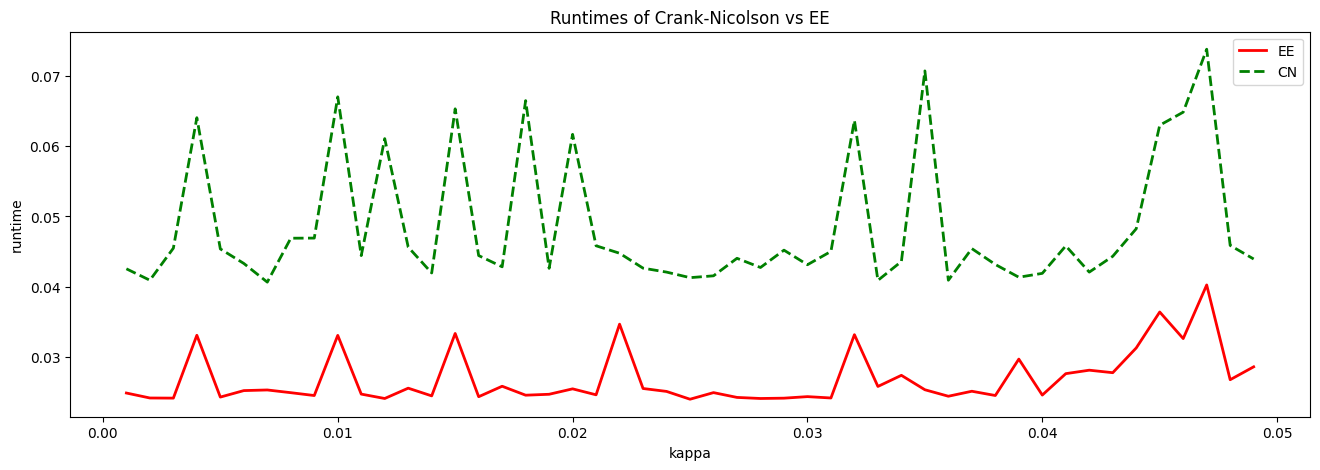

In [204]:
plt.figure(figsize=(16, 5))

plt.plot(kappas, ee_runtimes, 'r', label='EE', linewidth=2)
plt.xlabel('kappa')
plt.ylabel('runtime')
plt.title('Runtimes of Crank-Nicolson vs EE')

plt.plot(kappas, cn_runtimes, 'g--', label='CN', linewidth=2)
plt.legend()

plt.show()

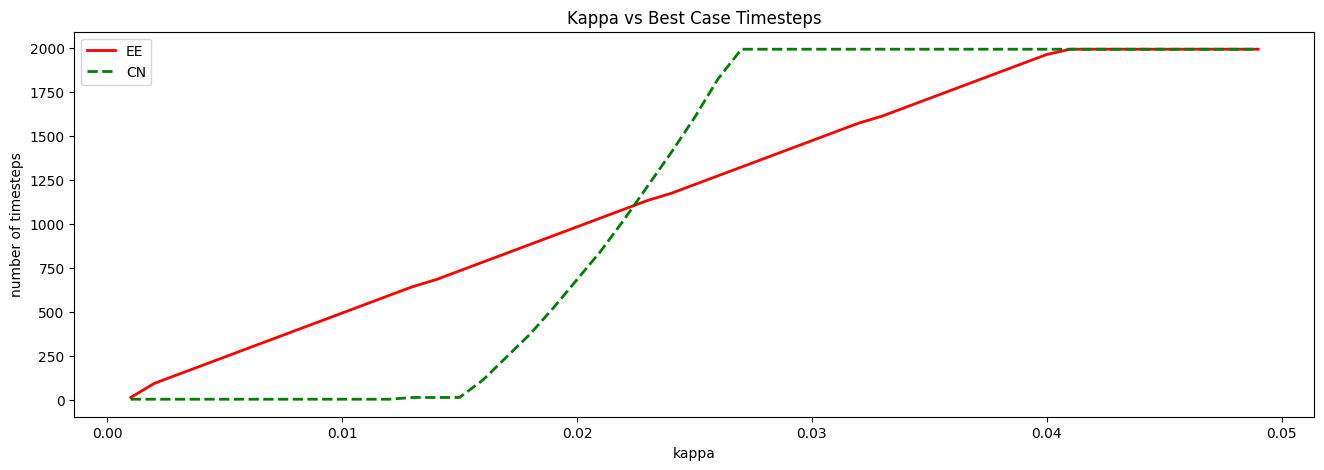

In [207]:
plt.figure(figsize=(16, 5))

plt.plot(kappas, ee_nts, 'r', label='EE', linewidth=2)
plt.xlabel('kappa')
plt.ylabel('number of timesteps')
plt.title('Kappa vs Best Case Timesteps')

plt.plot(kappas, cn_nts, 'g--', label='CN', linewidth=2)
plt.legend()

plt.show()

If we evaluate the runtime of Crank-Nicolson (CN) and Explicit Euler (EE), we see they run in O(num_timesteps). Therefore, after choosing an error threshold, we can identify whether EE or CN is more efficient by finding the lowest number of timesteps required to stay within that threshold. I started with a high number of timesteps and backed off until I found that the error tolerance was exceeded, then simulated a number of trials using that timestep to approximate the runtime of the method. I performed this for a range of kappa. For my chosen tolerance, the EE performed better across kappa, likely because it is less computationally expensive. I also plotted the minimum number of timesteps needed for various kappa (the plateau at 2000 can be interpreted as kappas for which a method wasn't able to perform within the error tolerance for my maximum number of timesteps).

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

At the boundary, ∂𝑥𝑐=0, so c_-1 = c_1. Therefore, for n=0 the expression used to construct the matrix, c_n-1 - 2c_n + c_n+1, can become -2c_0 + 2c_1.

Therefore the first row of the coefficient matrix becomes -2,2,0,0,0.... By symmetry, the last row becomes 0,0,0,....2,-2.

We can run CN with these conditions, and check along x to verify that there are no discrepancies.

In [7]:
def construct_M_adjusted(x):
# Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    dx = x[1] - x[0]  # Infer the uniform grid spacing
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1))
    M[0,1] = 2
    M[-1,-2] = 2
    # Just to show the shape of the matrix
    print(M)
    M = M / dx**2
    M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
    return M

def CN_adjusted(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M_adjusted(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    # print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

In [10]:
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

cn = CN_adjusted(x, t, kappa) # Crank-Nicolson

for i in range(Nt):
  gradient = cn[0,i] - cn[1,i]
  if gradient != 0:
    print("Discrepancy", gradient)


[[-2.  2.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  2. -2.]]


ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)

Dirichlet:

Say we want to fix x=0 to a, and x=L to b.
We can update the boundary conditions in the loop:

```
    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = a
        c[-1, k] = b
```

Neumann:

Say that the boundary condition at ∂𝑥c(0,t) is the function h and that the condition at L is ∂𝑥c(L,t) = g. Therefore, using the finite differences equation

df/dx = (f_n+1 - f_n-1)/2dx

we find that we need to add a column vector scaled by 2dx with a top row h and a bottom row g, with the remaining rows equalling 0.  